In [1]:
import json

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")

import rental_utils; reload(rental_utils)

<module 'rental_utils' from 'rental_utils.pyc'>

In [2]:
train_raw = pd.read_json('Data/train.json')
test_raw = pd.read_json('Data/test.json')

[features, feature_names] = rental_utils.get_features(25, train_raw)

train = rental_utils.add_features(train_raw, features, feature_names)
test = rental_utils.add_features(test_raw, features, feature_names)

train = rental_utils.add_region(train)
test = rental_utils.add_region(test)

train = rental_utils.add_variables(train, train)
test = rental_utils.add_variables(test, train)

dv_county = rental_utils.vectorizer('County', train)
train = rental_utils.one_hot_encode(dv_county, train, 'County')
test = rental_utils.one_hot_encode(dv_county, test, 'County')

dv_name = rental_utils.vectorizer('Name', train)
train = rental_utils.one_hot_encode(dv_name, train, 'Name')
test = rental_utils.one_hot_encode(dv_name, test, 'Name')

dv_region = rental_utils.vectorizer('RegionID', train)
train = rental_utils.one_hot_encode(dv_region, train, 'RegionID')
test = rental_utils.one_hot_encode(dv_region, test, 'RegionID')

independent = (['bathrooms', 'bedrooms', 'price'] + feature_names + 
    ['description_length', 'n_features', 'n_photos', 'month'] +
    [x for x in train.columns.values if 'County' in x] +
    [x for x in train.columns.values if 'Name' in x] +
    [x for x in train.columns.values if 'Region' in x]
    )
X_train, X_val, y_train, y_val = train_test_split(train[independent], train['interest_level'], test_size=0.33)

In [3]:
n_estimators = [10, 25, 50, 100]
max_features = [None, 'sqrt', 'log2'] 

hyperparameters = {
    'n_estimators': n_estimators, 
    'max_features': max_features
}

gridCV = GridSearchCV(RandomForestClassifier(), param_grid=hyperparameters, cv=10, n_jobs=4)

gridCV.fit(X_train, y_train)

# Identify optimal hyperparameter values
best_n_estim      = gridCV.best_params_['n_estimators']
best_max_features = gridCV.best_params_['max_features']  

print("The best performing n_estimators value is: {}".format(best_n_estim))
print("The best performing max_features value is: {}".format(best_max_features))

The best performing n_estimators value is: 100
The best performing max_features value is: None


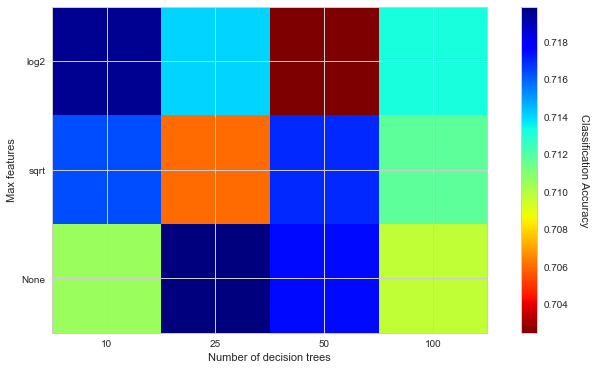

In [4]:
scores = gridCV.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(n_estimators), len(max_features))
scores = np.transpose(scores)

# Make heatmap from grid search results
plt.figure(figsize=(12, 6))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap='jet_r')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_features)), max_features)
plt.xlabel('Number of decision trees')
plt.ylabel('Max features')
plt.colorbar().set_label('Classification Accuracy', rotation=270, labelpad=20)
plt.show()